In [35]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataset_tools import *
%matplotlib inline

In [2]:

# l = [i for i in open('/media/hpc2_storage/nvaulin/test_ties32/list.txt') if i.find('PTZ') < 0]
# f = open('/media/hpc2_storage/nvaulin/test_ties32/list.txt','w')
# for i in l:
#     f.write(i)
    
# f.close()

In [171]:
def images_to_patches(imgs,cols,rows,h,w):
    assert len(imgs.shape) == 4
    c = imgs.shape[-1]
    return np.transpose(imgs.reshape((-1,rows,h,cols,w,c)),(1,3,0,2,4,5)).reshape(cols*rows,len(imgs),h,w,c)
    

def process_batch(imgs,masks,w,h,min_roi):
    '''
    return 
    ties - n_samples x length x h x w x 3
    ties_mask - n_samples x length x h x w
    positions - n_samples x [x,y]
    '''
    cols = imgs.shape[2]//w
    rows = imgs.shape[1]//h
    imgs = imgs[:,:h*rows,:w*cols,:]
    masks = masks[:,:h*rows,:w*cols]
    imgs = images_to_patches(imgs,cols,rows,h,w)
    masks = images_to_patches(masks.reshape(masks.shape+(1,)),cols,rows,h,w)[...,0]
    positions = np.zeros((1,rows*h,cols*w,2),dtype=np.int32)
    positions[0,:,:,0] += np.arange(cols*w)[None,:]
    positions[0,:,:,1] += np.arange(rows*h)[:,None]
    positions = images_to_patches(positions,cols,rows,h,w)
    positions = positions[:,0,0,0,:]
    roi = np.zeros_like(masks)
    roi[(masks > 240) | (masks < 10)] = 1
    roi = roi.mean((1,2,3))
    imgs,masks,positions = imgs[roi>=min_roi],masks[roi>=min_roi],positions[roi>=min_roi]
    return imgs,masks,positions

def get_motion(ties,masks,positions,min_motion,start_num):
    '''
    return n_samples list of
    ties - n_motion_ties x h x w x 3
    ties_mask - n_motion_ties x h x w
    positions - n_motion_ties x [x,y] positions of ties
    index - n_motion_ties index of ties
    '''
    motion_mask = np.zeros_like(masks)
    motion_mask[(masks > 240)] = 1
    motion_mask = motion_mask.mean((2,3))
    inx = np.arange(len(masks[0])).astype(np.int32)
    motion = []
    for i in range(len(masks)):
        m = motion_mask[i] >= min_motion
        p = (positions[i][0],positions[i][1])
        motion.append((p,ties[i][m],masks[i][m],inx[m]+start_num))
    return motion

def generate_ties(dataset,imdb,length,tie_size,min_motion,min_roi):
    def save_motion_hist(key,hist):
        key = imdb+key
        make_path(key[:key.rfind('/')])
        cv2.imwrite(key+'hist.png',hist)
    def save(key,img,mask):
        key = imdb+key
        make_path(key[:key.rfind('/')])
        img = ties_to_image(img)
        cv2.imwrite(key+'.jpg',img)
        if not(mask is None):
            mask = ties_to_image(mask)
            cv2.imwrite(key+'.png',mask)
            
    for path in iterate_folders(dataset):
        all_motion = dict()
        all_names = []
        in_dir = path[len(dataset):]
        for batch_num,(names,imgs,masks) in enumerate(iterate_bathced(path,length)):
            ties, masks,positions = process_batch(imgs,masks,tie_size,tie_size,min_roi)
            if(len(ties) == 0):
                continue
            for t,m,p in zip(ties,masks,positions):                    
                key = '%s/%d_%d/%s_%s'%(in_dir,p[0],p[1],names[0],names[-1])
                save(key,t, None if m[m>30].size == 0 else m)
                
            motion = get_motion(ties,masks,positions,min_motion,batch_num*length)
            for position,patch,mask,inx in motion:
                if not(position in all_motion):
                    all_motion[position] = ([],[],[])
                all_motion[position][0].append(patch)
                all_motion[position][1].append(mask)
                all_motion[position][2].append(inx)
            all_names.append(names)
            
        all_names = np.array(sum(all_names,[]))
        for position,(ties,mask,inx) in all_motion.iteritems():
            ties = np.concatenate(tuple(ties))
            mask = np.concatenate(tuple(mask))
            inx  = np.concatenate(tuple( inx))
            key = '%s/%d_%d/'%(in_dir,position[0],position[1])
            if(len(ties) > 0):
                motion_info = open(imdb+key+'motion_info.txt','w')
                for n in all_names[inx]:
                    motion_info.write(n+'\n')
                motion_info.close()
                save(key+'motion',ties,mask)
                motion_hist = np.zeros_like(mask,dtype=np.int32)
                motion_hist[mask > 240] = 1
                motion_hist = np.clip(motion_hist.sum(0),0,255).astype(np.uint8)
                save_motion_hist(key,motion_hist)
        break
    return motion_info
            
class PatchLoader(object):
    def __init__(self,root,t_size,seq_l,min_m,max_m,out_size):
        assert (out_size//2)*2+1 == out_size,'out_size must be odd'
        self.root,self.seq_l,self.out_size = root,seq_l,out_size
        self.min_m,self.max_m = np.ceil(min_m*float(seq_l)),np.floor(max_m*float(seq_l))
        self.t_size = t_size
        self.patches = []
        self.motions = []
        self.hist = []
        self.motion_names = []
        pad = self.out_size//2
        for video in iterate_folders(root):
            for p in os.listdir(video):
                prefix = video+'/'+p+'/'
                hist = cv2.imread(prefix+'hist.png',0)
                if(hist is None):
                    continue                      
                hist = hist[pad:hist.shape[0]-pad,pad:hist.shape[1]-pad]
                if(hist.max() < self.min_m):
                    continue
                self.hist.append(hist)
                all_jpg = [ prefix+i[:i.rfind('.')] for i in os.listdir(prefix) if i.find('jpg') > 0]
                self.motions.append([ i for i in all_jpg if i.find('motion') > 0][0])
                self.patches.append([ i for i in all_jpg if i.find('motion') < 0])
                self.motion_names.append(np.array([i[:-1] for i in open(prefix+'motion_info.txt')]))
                
    def load(self,path):
        patches = cv2.imread(path+'.jpg')
        patches = image_to_ties(patches,self.t_size,self.t_size)
        if(os.path.exists(path+'.png')):
            mask = image_to_ties(cv2.imread(path+'.png',0),self.t_size,self.t_size)
        else:
            mask = np.zeros_like(patches[:,:,:,0])
        return patches,mask

    def load_patch(self,patch_inx,inx):
        path = self.patches[patch_inx][inx]
        names = [int(i) for i in path[path.rfind('/')+1:].split('_')]
        names = np.array(['%06d'%i for i in range(names[0],names[1]+1)])
        patches,mask = self.load(path)
        return patches,mask,names

    def load_motion(self,patch_inx):
        patches,mask = self.load(self.motions[patch_inx])
        patches = patches[patches.sum((1,2,3)) > 0]
        mask = mask[:len(patches)]
        return patches,mask,self.motion_names[patch_inx]
        
    def balance_tie(self,patch_inx,patches,mask,x,y,names):
        means = np.zeros_like(mask)
        means[mask > 240] = 1
        print means.sum(0)
        means = np.zeros(len(mask))
        means[mask[:,y,x] > 240] = 1
        
        print(means.sum())
        if(means.sum() > self.max_m):
            return None,None,None
        elif(means.sum() < self.min_m):
            m_patch,m_mask,m_names = self.load_motion(patch_inx)
            m_patch = m_patch[m_mask[:,x,y] > 240]
            m_names = m_names[m_mask[:,x,y] > 240]
            m_mask = m_mask[m_mask[:,x,y] > 240]
            saples_to_add = int(self.min_m-means.sum())
            inx = np.random.choice(np.arange(0,len(m_mask)).astype(np.int32),saples_to_add)
            patches[means < 0.5][:saples_to_add] = m_patch[inx]
            mask   [means < 0.5][:saples_to_add] = m_mask [inx]
            names  [means < 0.5][:saples_to_add] = m_names[inx]
            return patches,mask,names
        else:
            ties,mask,names
    
    def load_sample(self,patch_inx,inx=None):
        pos = tuple([int(i) for i in self.patches[patch_inx][inx].split('/')[-2].split('_')])
        hist = self.hist[patch_inx].copy()
        p = np.zeros_like(hist,dtype=np.float32).flatten()
        p[hist.flatten() > self.min_m] = 1.
        y,x = np.unravel_index(int(np.random.choice(np.arange(hist.size),p=p/p.sum())),hist.shape)
        print(hist[y,x])
        patches,mask,names = self.load_patch(patch_inx,inx)
        patches,mask,names = patches[:self.seq_l],mask[:self.seq_l] ,names[:self.seq_l]
        patches,mask,names = self.balance_tie(patch_inx,patches,mask,x+self.out_size//2+1,y+self.out_size//2+1,names)
        pos = (pos[0]+x,pos[1]+y)
        return patches[:,y:y+self.out_size,y:y+self.out_size],mask[:,y:y+self.out_size,y:y+self.out_size],names,pos

    def get_position(patch_inx):
        path = self.motions[patch_inx]
        
    
pl = PatchLoader('out',32,256,0.3,0.5,5)



78
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [24 25 25 ... 25 25 24]
 [24 25 25 ... 25 25 24]
 [24 25 25 ... 25 25 24]]
25.0


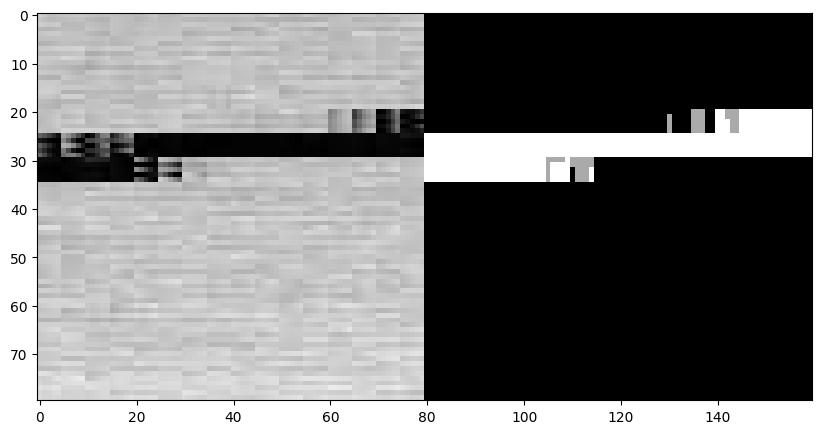

In [172]:
im,m,n,pos = pl.load_sample(2,0)
draw(im,m)

In [110]:
pos

(608, 352)

In [51]:
pl.motion_names[0][12]

'004799'

In [ ]:
def test_patch_loader(dir,patch_size,max_seq_l):
    max_m = (0.01+np.random.rand())*0.9
    min_m = np.random.rand()*max_m
    o_size = int(np.random.randint(1,patch_size))
    pl = PatchLoader(dir,patch_size,int(np.random.randint(10,max_seq_l+1)),min_m,max_m,24)
    

In [49]:
n

array(['002280', '002281', '002282', '002283', '002284', '002285',
       '002286', '002287', '002288', '002289', '002290', '002291',
       '002292', '002293', '002294', '002295', '002296', '002297',
       '002298', '002299', '002300', '002301', '002302', '002303',
       '002304', '002305', '002306', '002307', '002308', '002309',
       '002310', '002311', '002312', '002313', '002314', '002315',
       '002316', '002317', '002318', '002319', '002320', '002321',
       '002322', '002323', '002324', '002325', '002326', '002327',
       '002328', '002329', '002330', '002331', '002332', '002333',
       '002334', '002335', '002336', '002337', '002338', '002339',
       '002340', '002341', '002342', '002343', '002344', '002345',
       '002346', '002347', '002348', '002349', '002350', '002351',
       '002352', '002353', '002354', '002355', '002356', '002357',
       '002358', '002359', '002360', '002361', '002362', '002363',
       '002364', '002365', '002366', '002367', '002368', '0023

In [21]:
info = generate_ties('data/test','out',256,32,0.2,0.5)

NameError: global name 'motion_infomotion_info' is not defined

In [8]:
print info['data/test/badWeather/blizzard']['positions'][(0,0)]['patches']

['data/test/badWeather/blizzard/0_0/000900_001155.jpg', 'data/test/badWeather/blizzard/0_0/001156_001411.jpg', 'data/test/badWeather/blizzard/0_0/001412_001667.jpg', 'data/test/badWeather/blizzard/0_0/001668_001923.jpg', 'data/test/badWeather/blizzard/0_0/001924_002179.jpg', 'data/test/badWeather/blizzard/0_0/002180_002435.jpg', 'data/test/badWeather/blizzard/0_0/002436_002691.jpg', 'data/test/badWeather/blizzard/0_0/002692_002947.jpg', 'data/test/badWeather/blizzard/0_0/002948_003203.jpg', 'data/test/badWeather/blizzard/0_0/003204_003459.jpg', 'data/test/badWeather/blizzard/0_0/003460_003715.jpg', 'data/test/badWeather/blizzard/0_0/003716_003971.jpg']


data/test/badWeather/blizzard


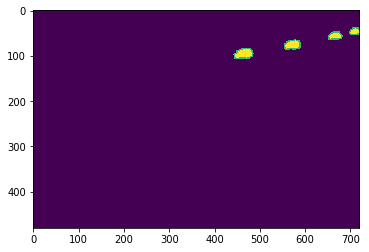

name= 000923


In [17]:
dataset,length,tie_size,min_motion,min_roi = 'data/test',32,32,0.01,0.5
for in_dir in iterate_folders(dataset):
        print in_dir
        all_motion = None
        all_names = None
        for batch_num,(names,imgs,masks) in enumerate(iterate_bathced(in_dir,length)):
            plt.imshow(masks[23])
            plt.show()
            print 'name=',names[23]
            ties, masks,positions = process_batch(imgs,masks,tie_size,tie_size,min_roi)
            motion = get_motion(ties,masks,positions,min_motion,batch_num*length)
            if(all_motion is None):
                all_motion = motion
                all_names = names
            else:
                all_motion = merge_motion_ties(all_motion,motion)
                all_names = all_names+names
            break
        break

In [22]:
all_motion[0]

(array([], shape=(0, 32, 32, 3), dtype=uint8),
 array([], shape=(0, 32, 32), dtype=uint8),
 array([0, 0], dtype=int32),
 array([], dtype=int32))

In [3]:
def get_motion_ties(img,_mask,t_size):
    mask = np.zeros_like(_mask,dtype=np.float32)
    mask[_mask > 240] = 1
    c = np.cumsum(mask,0)
    c = np.cumsum(c,1)
    mask = (c[t_size:,t_size:] + c[:-t_size,:-t_size] - c[:-t_size,t_size:] - c[t_size:,:-t_size])/(t_size**2)
    h = w = t_size//2
    cols = mask.shape[1]//w
    rows = mask.shape[0]//h
    mask = mask[:h*rows,:w*cols]
    x_inx = np.arange(mask.shape[1])[None,:]+mask*0
    y_inx = np.arange(mask.shape[0])[:,None]+mask*0
    mask = np.transpose(mask.reshape((rows,h,cols,w)),(0,2,1,3)).reshape(cols*rows,h*w)
    y_inx = np.transpose(y_inx.reshape((rows,h,cols,w)),(0,2,1,3)).reshape(cols*rows,h*w).astype(np.int32)
    x_inx = np.transpose(x_inx.reshape((rows,h,cols,w)),(0,2,1,3)).reshape(cols*rows,h*w).astype(np.int32)
    res = []
    for i in np.arange(len(mask))[mask.max(1) > 0.95]:
        inx = mask[i].argmax()
        x = x_inx[i][inx]
        y = y_inx[i][inx]
        res.append(img[y:y+t_size,x:x+t_size])
    return np.array(res)

def get_motion_batch(imgs,masks,t_size):
    res = np.empty((0,t_size,t_size,3),dtype=np.uint8)
    for i in range(len(imgs)):
        tmp = get_motion_ties(imgs[i],masks[i],t_size)
        if(len(tmp) > 0):
            res = np.concatenate((res,tmp),axis=0)
    return res

def process_batch(out_dir,imgs,masks,w,h,min_r,min_roi):
    cols = imgs.shape[2]//w
    rows = imgs.shape[1]//h
    imgs = imgs[:,:h*rows,:w*cols,:]
    masks = masks[:,:h*rows,:w*cols]
    imgs = np.transpose(imgs.reshape((-1,rows,h,cols,w,3)),(1,3,0,2,4,5)).reshape(cols*rows,len(imgs),h,w,3)
    masks = np.transpose(masks.reshape((-1,rows,h,cols,w)),(1,3,0,2,4)).reshape(cols*rows,len(masks),h,w)
    motion = np.zeros_like(masks)
    motion[masks > 240] = 1
    motion = motion.mean((2,3))

    roi = np.zeros_like(masks)
    roi[(masks > 240) | (masks < 10)] = 1
    roi = roi.mean((2,3))
    iter = 0
    for i in range(len(masks)):
        if(motion[i].mean() >= min_r and roi[i].mean() >= min_roi):
            cv2.imwrite(out_dir+'/%d_input.jpg'%(iter),ties_to_image(imgs[i]))
            cv2.imwrite(out_dir+'/%d_mask.png'%(iter),ties_to_image(masks[i]))
            iter+=1
    return imgs.reshape((-1,h,w,3))[motion.flatten()>=.97],iter

def save_motion(out_dir,motion_ties):
    if not (motion_ties is None):
        for i in range(int(np.ceil(float(len(motion_ties))/50.))):
            im = ties_to_image(motion_ties[i*50:min((i+1)*50,len(motion_ties))],5,10)
            cv2.imwrite(out_dir+'/%d_motion.jpg'%(i),im)
        return len(motion_ties)
    else:
        return 0

In [4]:
def generate_ties(dataset,out_dir,length,tie_size,min_r=0,min_roi = 0.5):
    for video_num,(in_dir,out_dir) in enumerate(iterate_folders(dataset,out_dir)):
        ties_num = 0
        motion_ties = None
        for batch_num,(imgs,masks) in enumerate(iterate_bathced(in_dir,length)):
            _,i = process_batch(out_dir,imgs,masks,tie_size,tie_size,min_r,min_roi)
            ties_num += i
            m_ties = get_motion_batch(imgs,masks,tie_size)
            if(len(m_ties) > 0):
                if not(motion_ties is None):
                    motion_ties = np.concatenate((motion_ties,m_ties))
                else:
                    motion_ties = m_ties
        print out_dir+ ' %d ties=%d motion=%d'%(batch_num,ties_num,save_motion(out_dir,motion_ties))

In [5]:
TIE_SIZE = 64
out_prefix = 'data/ties%d'%TIE_SIZE
in_dir = 'data/dataset'
SEQ_LENGTH = 64
generate_ties(in_dir,out_prefix,SEQ_LENGTH,TIE_SIZE,-1.,0.5)

data/ties64/turbulence/turbulence2 61 ties=1240 motion=0
data/ties64/turbulence/turbulence3 20 ties=847 motion=1268
data/ties64/turbulence/turbulence1 42 ties=1694 motion=0
data/ties64/thermal/lakeSide 84 ties=1275 motion=0
data/ties64/thermal/park 4 ties=100 motion=0
data/ties64/thermal/diningRoom 45 ties=690 motion=372
data/ties64/thermal/library 66 ties=1005 motion=18914
data/ties64/PTZ/zoomInZoomOut 8 ties=75 motion=0
data/ties64/PTZ/twoPositionPTZCam 22 ties=240 motion=4
data/ties64/PTZ/intermittentPan 34 ties=720 motion=6
data/ties64/dynamicBackground/overpass 30 ties=434 motion=164
data/ties64/dynamicBackground/fall 45 ties=3542 motion=8992
data/ties64/dynamicBackground/canoe 5 ties=90 motion=0
data/ties64/dynamicBackground/fountain02 14 ties=360 motion=0
data/ties64/dynamicBackground/fountain01 11 ties=288 motion=0
data/ties64/shadow/peopleInShade 13 ties=210 motion=578
data/ties64/shadow/cubicle 97 ties=1470 motion=537
data/ties64/shadow/copyMachine 44 ties=3465 motion=24725
d

In [6]:
TIE_SIZE = 64
out_prefix = 'data/test_ties%d'%TIE_SIZE
in_dir = 'data/test'
SEQ_LENGTH = 64
generate_ties(in_dir,out_prefix,SEQ_LENGTH,TIE_SIZE,-1.,0.5)

data/test_ties64/turbulence/turbulence0 61 ties=2387 motion=0
data/test_ties64/thermal/corridor 75 ties=1140 motion=1866
data/test_ties64/PTZ/continuousPan 16 ties=693 motion=740
data/test_ties64/dynamicBackground/boats 94 ties=475 motion=0
data/test_ties64/shadow/backdoor 24 ties=296 motion=0
data/test_ties64/nightVideos/bridgeEntry 22 ties=131 motion=0
data/test_ties64/intermittentObjectMotion/abandonedBox 31 ties=63 motion=0
data/test_ties64/baseline/highway 18 ties=285 motion=91
data/test_ties64/cameraJitter/badminton 4 ties=385 motion=124
data/test_ties64/lowFramerate/port_0_17fps 30 ties=624 motion=0
data/test_ties64/badWeather/blizzard 94 ties=3696 motion=3184


In [16]:
import shutil
def purge(dir):
    for i in os.listdir(dir):
        for j in os.listdir(dir+'/'+i):
            p = dir+'/'+i+'/'+j
            l = [k[:-4] for k in os.listdir(p)]
            if( not('0_motion' in l)):
                print(p,'no motion ',len(l))
                shutil.rmtree(p)
            else:
                print(p,len(l))
purge('/media/hpc2_storage/nvaulin/ties32')        
purge('/media/hpc2_storage/nvaulin/test_ties32')           

('/media/hpc2_storage/nvaulin/ties32/turbulence/turbulence2', 'no motion ', 360)
('/media/hpc2_storage/nvaulin/ties32/turbulence/turbulence3', 683)
('/media/hpc2_storage/nvaulin/ties32/turbulence/turbulence1', 661)
('/media/hpc2_storage/nvaulin/ties32/thermal/lakeSide', 139)
('/media/hpc2_storage/nvaulin/ties32/thermal/park', 199)
('/media/hpc2_storage/nvaulin/ties32/thermal/diningRoom', 225)
('/media/hpc2_storage/nvaulin/ties32/thermal/library', 524)
('/media/hpc2_storage/nvaulin/ties32/PTZ/zoomInZoomOut', 'no motion ', 136)
('/media/hpc2_storage/nvaulin/ties32/PTZ/twoPositionPTZCam', 123)
('/media/hpc2_storage/nvaulin/ties32/PTZ/intermittentPan', 384)
('/media/hpc2_storage/nvaulin/ties32/dynamicBackground/overpass', 136)
('/media/hpc2_storage/nvaulin/ties32/dynamicBackground/fall', 898)
('/media/hpc2_storage/nvaulin/ties32/dynamicBackground/canoe', 'no motion ', 102)
('/media/hpc2_storage/nvaulin/ties32/dynamicBackground/fountain02', 'no motion ', 234)
('/media/hpc2_storage/nvaulin/t